In [ ]:
import numpy as np
from keras import layers
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Add, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, Dense, Dropout, Activation, Flatten, BatchNormalization, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.optimizers import SGD
import tensorflow as tf
from tensorflow.python.keras.metrics import Metric
from keras import optimizers
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt 
from keras.initializers import glorot_uniform
from keras.layers import Input


In [ ]:
#  REFERENCED FROM  https://github.com/fchollet/deep-learning-models

In [ ]:
num_classes=100

In [ ]:
from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

169009152/169001437 [==============================] - 4s 0us/step


In [ ]:
x_shape = x_train[0].shape
x_shape

(32, 32, 3)

In [ ]:
def identity_block(X, f, filters):
      
    # Retrieve Filters
    F1, F2 = filters
    
    # Save the input value
    X_shortcut = X
    X_shortcut = Dropout(0.1)(X_shortcut)
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = Activation('elu')(X)
    X = Dropout(0.1)(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same')(X)
    X = Activation('elu')(X)
    X = Dropout(0.1)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('elu')(X)
    return X


def convolutional_block(X,f,filters,s=2):


    # Retrieve Filters
    F1, F2 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid')(X)
    X = Activation('elu')(X)
    X = Dropout(0.1)(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = Activation('elu')(X)
    X = Dropout(0.1)(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F2, kernel_size=(1, 1), strides=(s, s), padding='valid')(X_shortcut)
    X_shortcut = Dropout(0.1)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('elu')(X)

    return X

def ResNet18(input_shape = x_shape, classes = 100):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X,f=3,filters = [64, 64],s=1)
    X = identity_block(X, 3, [64, 64])
    

    # Stage 3
    X = convolutional_block(X,f=3,filters=[128, 128],s=2)
    X = identity_block(X, 3, [128, 128])
    

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256],s=2)
    X = identity_block(X, 3, [256, 256])
 

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512],s=2)
    X = identity_block(X, 3, [512, 512])


    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet18')

    return model


In [ ]:
model = ResNet18(input_shape = (32, 32, 3), classes = 100)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
batch_size = 128
maxepoches = 200
learning_rate = 0.0001

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

sgd = optimizers.Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])


# training process in a for loop with learning rate drop every 25 epoches.

history = model.fit(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=maxepoches,
                    validation_data=(x_test, y_test),callbacks=[callback],verbose=2)

model.save_weights("/content/gdrive/My Drive/checkpoint/Resnet18_ADAM_Dropout.ckpt")

Epoch 1/200
391/391 - 27s - loss: 4.0318 - accuracy: 0.0828 - val_loss: 3.5543 - val_accuracy: 0.1566
Epoch 2/200
391/391 - 26s - loss: 3.5539 - accuracy: 0.1537 - val_loss: 3.3094 - val_accuracy: 0.2007
Epoch 3/200
391/391 - 26s - loss: 3.3531 - accuracy: 0.1879 - val_loss: 3.1354 - val_accuracy: 0.2328
Epoch 4/200
391/391 - 26s - loss: 3.2134 - accuracy: 0.2160 - val_loss: 2.9597 - val_accuracy: 0.2681
Epoch 5/200
391/391 - 26s - loss: 3.1171 - accuracy: 0.2352 - val_loss: 2.9120 - val_accuracy: 0.2733
Epoch 6/200
391/391 - 26s - loss: 3.0258 - accuracy: 0.2486 - val_loss: 2.8497 - val_accuracy: 0.2870
Epoch 7/200
391/391 - 26s - loss: 2.9601 - accuracy: 0.2633 - val_loss: 2.7578 - val_accuracy: 0.3082
Epoch 8/200
391/391 - 26s - loss: 2.8827 - accuracy: 0.2774 - val_loss: 2.6475 - val_accuracy: 0.3314
Epoch 9/200
391/391 - 26s - loss: 2.8212 - accuracy: 0.2891 - val_loss: 2.5721 - val_accuracy: 0.3416
Epoch 10/200
391/391 - 26s - loss: 2.7779 - accuracy: 0.2952 - val_loss: 2.6400 - 

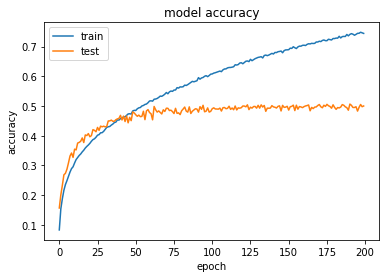

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

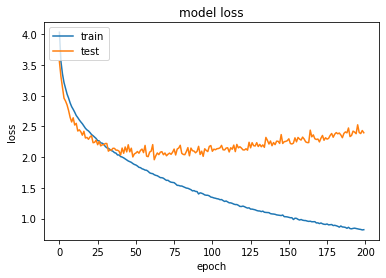

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd
from keras.datasets import cifar100
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_test = x_test.astype('float32')
x_test = x_test / 255.0
y_pred = model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
y_pred=pd.DataFrame(y_pred)
y_test=pd.DataFrame(y_test)

p=precision_score(y_test, y_pred,average='weighted',labels=np.unique(y_pred))
r=recall_score(y_test,y_pred,average='micro',labels=np.unique(y_pred))
print('Precision Is:',p)
print('Recall Is:',r)

Precision Is: 0.5043282528238467
Recall Is: 0.4999
